# Import libraries

In [1]:
%load_ext autoreload
%autoreload 1

In [375]:
# Importing libraries
import re
import os
import pandas as pd
import numpy as np

# Import libraries for plotting
import matplotlib.pyplot as plt
import plotly.express as px

# Import libraries for listing countries
#import pycountry
#import pycountry_convert as pc

# Import aux libraries
from collections import Counter
import re
import copy
#from wordcloud import WordCloud

# Import libraries for Spacy
import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher 


In [3]:
# Import tools for clustering
import umap.umap_ as umap
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import PartOfSpeech
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

In [4]:
# Check CUDA on torch
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is properly installed
print(torch.cuda.current_device())  # Returns the index of the current CUDA device
print(torch.cuda.get_device_name(torch.cuda.current_device())) 

True
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [10]:
# Import transformers and others
from transformers import pipeline
from sentence_transformers import SentenceTransformer, SimilarityFunction, util
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [6]:
# Import sk
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# Import pycountry
import pycountry
import pycountry_convert as pc

In [7]:
# Import own libraries
from extract_info import extract_abstracts_bib

In [8]:
%aimport extract_info

# Import information

## Load the data extracted

In [9]:
# Create the excel file with the abstracts information
bib_directory   = '00_bibFiles'
bib_file        = 'search_003'
path_export     = extract_abstracts_bib(bib_file, bib_directory,'out')

The bib file search_003 was exported successfully with 7794 entries.


In [10]:
# From the extracted information, create a dataframe
bib_file        = 'search_003'
path_export_file = os.path.join('out', bib_file+'_export.xlsx')
df_base = pd.read_excel(path_export_file)
print(df_base.columns)
print(df_base.shape)

Index(['author', 'title', 'year', 'journal', 'url', 'doi', 'abstract',
       'author_keywords', 'keywords', 'type', 'publication_stage', 'source',
       'note'],
      dtype='object')
(7794, 13)


## Data preprocess
While using a parser provided by SentenceTransforomers there is no need to clearing the data since the model is already trained, however will be dicarted the abstracts that are far away 3STD from the mean. Finally the remaining abstracts longer than 512 tokens will be truncated by the parser.

In [11]:
# Filter out rows with missing abstracts or titles
shape_0 = df_base.shape[0]
df_base = df_base.dropna(subset=['abstract', 'title'])
df_base = df_base[df_base['abstract'] != 'NoData']
df_base = df_base[df_base['title'] != 'NoData']

df_base = df_base.reset_index(drop=True)

# Print how many rows were removed
print(f"Removed {shape_0 - df_base.shape[0]} rows with missing data")

# Create a new dataframe with the abstracts to analyze
df_analyze = df_base[['title', 'abstract']].copy()
df_analyze['id_base'] = df_base.index


Removed 4 rows with missing data


In [12]:

# Import model for tokenization
model_name  = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer   = AutoTokenizer.from_pretrained(model_name)
embedding_model = SentenceTransformer(model_name)

# Tokenize the abstracts
df_analyze['tokens'] = df_analyze['abstract'].apply(lambda x: tokenizer.encode(x))

# Plot the number of  tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))

# Plot the number of tokens with plotty
fig = px.histogram(df_analyze, x='token_length', nbins=50)
fig.update_layout(title='Number of tokens in abstracts')
fig.show()

print('Abstracts that exceeds 512 tokens:', len(df_analyze[df_analyze['token_length']>=512]))

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


Abstracts that exceeds 512 tokens: 228


In [13]:
# Find the STD of the number of tokens
mean_tokens = df_analyze['token_length'].mean()
std_tokens  = df_analyze['token_length'].std()

# Drop the abstracts that are of the range of 3 standard deviations
shape_1 = df_analyze.shape[0]
df_analyze = df_analyze[
                (df_analyze['token_length'] < mean_tokens + 3*std_tokens) &
                (df_analyze['token_length'] > 50)]
df_analyze = df_analyze.reset_index(drop=True)
shape_2 = df_analyze.shape[0]

print('Abstracts dropped:', shape_1 - shape_2)

Abstracts dropped: 82


# Clustering of topics

## Declare functions

In [19]:
#================================================================================================
# Function to rescale the embeddings (fromg BERTopic documentation)
#================================================================================================

def rescale(x, inplace=False):
  """ Rescale an embedding so optimization will not have convergence issues.
  """
  if not inplace:
      x = np.array(x, copy=True)
  x /= np.std(x[:, 0]) * 10000

  return x

#================================================================================================
# Define BERTopic model function
#================================================================================================

def BERTopic_model(docs, embeddings, n_comp=20, n_neigh=25, minS_cluster=5):
  # Initialize and rescale PCA embeddings
  pca_embeddings = rescale(PCA(n_components=n_comp).fit_transform(embeddings))

  # Embedding model
  embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
  #embedding_model = None

  # Reduce dimensionality
  umap_model      = umap.UMAP(n_neighbors=n_neigh, 
                              n_components=n_comp, 
                              metric='cosine',
                              random_state=42,
                              init=pca_embeddings,
                              )

  # Cluster the reduced data
  hdbscan_model   = hdbscan.HDBSCAN(min_cluster_size=minS_cluster, 
                                      metric='euclidean', 
                                      cluster_selection_method='eom',
                                      prediction_data = True)

  # Vectorizer
  vectorizer_model = CountVectorizer(stop_words="english",
                                      ngram_range=(1, 2),
                                      min_df=10)

  # Topic representation
  ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

  # Representation model
  representation_model = KeyBERTInspired()
  #representation_model = MaximalMarginalRelevance(diversity=0.3)

  # All steps together
  topic_model = BERTopic(
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
    representation_model=representation_model,# Step 6 - (Optional) Fine-tune topic representations
    calculate_probabilities=True
  )

  # Fit the BERTopic model
  topics, probs = topic_model.fit_transform(docs,  embeddings)

  return topics, probs, topic_model

#================================================================================================
# Function to calculate silhouette score of the clustering
#================================================================================================

def silhouette_score_calc(embeddings, topics):
  # Print the silhouette score
  non_noise_indices   = [i for i, topic in enumerate(topics) if topic != -1]
  filtered_embeddings = embeddings[non_noise_indices]
  filtered_topics     = [topics[i] for i in non_noise_indices]

  silhouette_vals     = silhouette_samples(filtered_embeddings, filtered_topics)
  silhouette_avg      = silhouette_score(filtered_embeddings, filtered_topics)

  # Create a DataFrame to hold the results
  results = pd.DataFrame({'topic': filtered_topics, 'silhouette_score': silhouette_vals})

  # Group by topic and calculate the average Silhouette score per topic
  avg_silhouette_per_topic = results.groupby('topic')['silhouette_score'].mean().reset_index()

  # Count how many topics are negative
  negative_topics = avg_silhouette_per_topic[avg_silhouette_per_topic['silhouette_score'] < 0].shape[0]

  return silhouette_avg, negative_topics

## Create embeddings

In [ ]:
# Embedding model using the specter model
embedding_model = SentenceTransformer("allenai-specter", device='cuda')

# Create embedding of abstracts
df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)
abstracts = df_analyze['specter']
embeddings_specter = embedding_model.encode(abstracts, show_progress_bar=True)

In [ ]:
# Embedding model using the MiniLM model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')

# Create embedding of abstracts
abstracts = df_analyze['abstract']
embeddings_MiniLM = embedding_model.encode(abstracts, show_progress_bar=True)

## Find the best parameters for clustering
- Parameters to evaluate: 
    - For dimension reduction with UMAP changing (neighbors size and number of components)
    - For HDBSCAN the minimum size of the cluster

In [20]:
# Embeddings to use
embedings_x     = embeddings_MiniLM

# Define the number of components, neighbors and minimum cluster size
n_comp_matrix   = [10, 20, 50, 100]
n_neigh_matrix  = [20, 50, 100]
n_ClusterSize   = [15, 20]

results = []
for k in n_ClusterSize:
    for i in n_comp_matrix:
        for j in n_neigh_matrix:
            topics, probs, topic_model = BERTopic_model(
                                            abstracts,
                                            embedings_x, 
                                            n_comp        = i, 
                                            n_neigh       = j, 
                                            minS_cluster  = k,
                                            
                                            )
            
            silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)

            # Count how many documents area noise (topic == -1)
            noise_docs = len([topic for topic in topics if topic == -1])

            # Store the results
            results.append({
                'n_minCluster':     k,
                'n_components':     i,
                'n_neighbors':      j,
                'silhouette_score': silhouette_avg,
                'negative_topics':  negative_topics,
                'noise_docs':       noise_docs
                })

# Create a DataFrame with the results
results = pd.DataFrame(results)
results = results.sort_values('silhouette_score', ascending=False)


## Clustering of Topics
From the previous step the parameters chosen are:

In [61]:
# Embeddings to use
embedings_x     = embeddings_MiniLM

# Selected parameters
## Specter: 15, 10, 100
## MiniLM:  20, 20, 50
_minCluster = 20
_components = 10
_neighbors  = 100

# Fit the BERTopic model
topics, probs, topic_model = BERTopic_model(
                                abstracts,
                                embedings_x, 
                                n_comp        = _components, 
                                n_neigh       = _neighbors, 
                                minS_cluster  = _minCluster,
                                )
silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)
print(f"Silhouette score: {silhouette_avg}")

Silhouette score: 0.06694741547107697


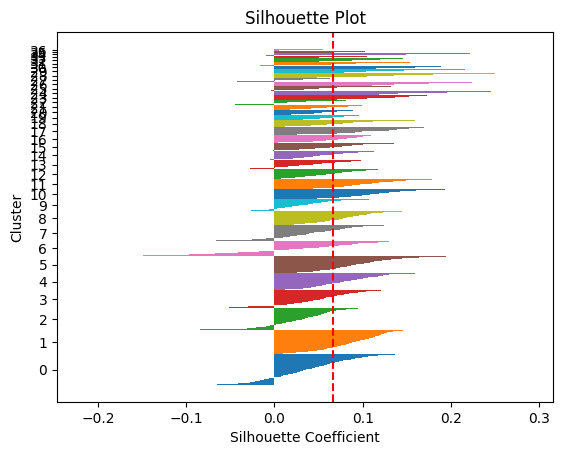

In [33]:

non_noise_indices   = [i for i, topic in enumerate(topics) if topic != -1]
filtered_embeddings = embedings_x[non_noise_indices]
filtered_topics     = [topics[i] for i in non_noise_indices]

silhouette_vals     = silhouette_samples(filtered_embeddings, filtered_topics)

# Number of clusters
n_clusters = len(np.unique(filtered_topics))

# Initialize the plot
fig, ax = plt.subplots()
y_lower, y_upper = 0, 0
yticks = []

# Iterate over clusters to plot silhouette scores
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[np.array(filtered_topics) == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

# Styling the plot
ax.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
ax.set_yticks(yticks)
ax.set_yticklabels(range(n_clusters))
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_title("Silhouette Plot")

plt.show()

In [45]:
# Reduce embeddings to 2D for visualization
reduced_embeddings = umap.UMAP( n_neighbors=_neighbors, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embedings_x)

# Get the abstracts information from the topic model
document_info = topic_model.get_document_info(abstracts)

# Visualize the topics
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)


In [36]:
topic_model.visualize_topics()

In [37]:
topic_model.visualize_hierarchy()

In [39]:
topic_model.visualize_term_rank()

## Reduction of topics
Analyzing the cluster manually start to discard cluster not revelant to the thesis topic and then start reducing the topics by joining close topics

In [40]:
repr_doc = document_info[['Topic','Representative_Docs']].explode('Representative_Docs').drop_duplicates()
print(repr_doc)

# Summarize the topics
summarizer = pipeline("summarization", model="Falconsai/text_summarization", device=0)
repr_doc['Summary_Rep'] = repr_doc['Representative_Docs'].apply(lambda x:summarizer(x, max_length=70, min_length=0, do_sample=True))



     Topic                                Representative_Docs
0        1  This study aims to recover the waste heat from...
0        1  The present study investigates an innovative m...
0        1  This study introduces a new solar-methane-driv...
2       17  Membrane-based gas separation is attracting mo...
2       17  The choice of carrier type in facilitated tran...
..     ...                                                ...
446     34  An increasing number of studies have demonstra...
446     34  The low oral bioavailability of clozapine due ...
614     30  We have recently shown that molecular hydrogen...
614     30  At least 20% of the world's natural gas origin...
614     30  Natural hydrogen (H2) has the potential to be ...

[108 rows x 2 columns]


Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [41]:
# Save the results
path_export = os.path.join('out', 'topics1.xlsx')
with pd.ExcelWriter(path_export) as writer:
    repr_doc.to_excel(writer, sheet_name='Representative_Docs', index=True)
    document_info.to_excel(writer, sheet_name='Results', index=True)

In [83]:
# Reduce outliers
#new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities=probs, 
#                             threshold=0.1, strategy="probabilities")

#new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", threshold=0.1)

# Use the "c-TF-IDF" strategy with a threshold
#new_topics = topic_model.reduce_outliers(abstracts, topics , strategy="c-tf-idf", threshold=0.05)

# Reduce all outliers that are left with the "distributions" strategy
new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="distributions", threshold=0.1)

topic_model.update_topics(abstracts, topics=new_topics, n_gram_range=(1, 2),ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True))
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

2024-08-25 23:35:37,174 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [78]:
check = topic_model.get_document_info(abstracts)


In [79]:
topic_distr, _ = topic_model.approximate_distribution(abstracts)

In [82]:
topic_model.visualize_distribution(topic_distr[40])

In [84]:
# Save the results
path_export = os.path.join('out', 'topics1_outliers.xlsx')
with pd.ExcelWriter(path_export) as writer:
    repr_doc.to_excel(writer, sheet_name='Representative_Docs', index=True)
    document_info.to_excel(writer, sheet_name='Results', index=True)

In [ ]:
# Add to df_analyze the topics
df_analyze['topic'] = topics
df_analyze['new_topic'] = new_topics

# Drop columns specter, tokens token_length
df_analyze = df_analyze.drop(columns=['specter', 'tokens', 'token_length'])

In [94]:
# Save the results
path_export = os.path.join('out', 'abstracts_topics.xlsx')
df_analyze.to_excel(path_export, index=False)

In [11]:
# Using ChatGPT-3 the topics of the clusters are found
path_export = os.path.join('out_rev', 'topics_ChatGPT.xlsx')
df_topics = pd.read_excel(path_export)

# Extract features

In [12]:
path_export = os.path.join('out_rev', 'abstracts_topics.xlsx')
df_analyze = pd.read_excel(path_export)

## Extract Countries

In [15]:
# Extract entities using the wikineural-multilingual-ner model

tokenizer   = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model       = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True, device=0)

# Extract entities from the abstracts
df_analyze['entities'] = df_analyze['abstract'].apply(lambda x: nlp(x))

# Extract entities from the title
df_analyze['entities_title'] = df_analyze['title'].apply(lambda x: nlp(x))

# Get a column with LOC entities
df_analyze['LOC'] = df_analyze.apply(lambda x: [entity['word'] for entity in (x['entities']+x['entities_title']) if entity['entity_group'] == 'LOC'], axis=1)
df_analyze['LOC'] = df_analyze['LOC'].apply(lambda x: list(set(x)))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Get the countries

In [140]:
def get_country_code(location):
    try:
        # Attempt to match the location as a country name
        country = pycountry.countries.lookup(location)
        return country.alpha_2
    except LookupError:
        pass
    
    try:
        # If not a country, check if it's a subdivision
        subdivision = pycountry.subdivisions.lookup(location)
        country = pycountry.countries.get(alpha_2=subdivision.country_code)
        return country.alpha_2
    except LookupError:
        return None

# Create a new dataframe with the LOC entities for cleaning
df_loc = df_analyze.explode('LOC')
df_loc = df_loc.groupby(['LOC']).size().reset_index(name='count')

# Apply the function to get country codes
df_loc['country_code'] = df_loc['LOC'].apply(lambda x: get_country_code(x) if x else None)

# Export the results for cleaning
path_export = os.path.join('out', 'locations.xlsx')
df_loc.to_excel(path_export, index=False)

In [221]:
# Import the excel with the country codes
path_export = os.path.join('out_rev', 'locations_clean.xlsx')
df_loc = pd.read_excel(path_export)

# Filter out rows with missing country codes
df_loc = df_loc.dropna(subset=['country_code'])

# Function to find the country code for a list of locations
def get_country_codes(loc_list, df_loc):
    country_codes = []
    for loc in loc_list:
        # Check if the location is in df_loc and get the corresponding country code
        matching_row = df_loc[df_loc['LOC'] == loc]
        if not matching_row.empty:
            country_codes.append(matching_row['country_code'].values[0])

    return country_codes

# Apply the function to the LOC column in df_analyze
df_analyze['country_code'] = df_analyze['LOC'].apply(lambda x: get_country_codes(x, df_loc) if isinstance(x, list) else [])
df_analyze['country_code'] = df_analyze['country_code'].apply(lambda x: list(set(x)))
df_analyze['n_countries'] = df_analyze['country_code'].apply(lambda x: len(x))


### Get the continents

In [222]:
# Mapping of continent codes to continent names
region_names = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'OC': 'Oceania',
    'ME': 'Middle East'  # Custom region for Middle East
}

# Lists of country codes for custom regions

## Create a Middle East region
middle_east_countries = {'EG', 'IR', 'IQ', 'JO', 'LB', 'OM', 'PS', 'QA', 'SA', 'SY', 'TR', 'AE', 'YE'}
ME_countries = {}
for country_code in middle_east_countries:
    ME_countries[country_code] = 'ME'

## Custom list mapping some countries to continents
custom_list = {    
    'Asia': 'AS', 
    'Europe': 'EU',
    'Africa': 'AF',
    'North America': 'NA',
    'South America': 'SA',
    'Middle East': 'ME',
    'BlackSea': 'EU',
    }

## List with the custom regions
custom_list.update(ME_countries)


# Function to get the continent or custom region name
def get_continent_region(country_code):
    # Check in the custom list first
    if country_code in custom_list:
        continent_code = custom_list[country_code]
    else:
        # If not in custom list, use pycountry_convert
        try:
            continent_code = pc.country_alpha2_to_continent_code(country_code)
        except KeyError:
            return None  # Return None if the country code is not recognized
    
    # Convert the continent code to a continent name
    return region_names.get(continent_code, 'Unknown')

# Apply the function to the country_code column
df_analyze['continent'] = df_analyze['country_code'].apply(
    lambda x: [get_continent_region(code) for code in x] if isinstance(x, list) else []
)
df_analyze['continent'] = df_analyze['continent'].apply(lambda x: list(set(x)))
df_analyze['n_locations']= df_analyze['LOC'].apply(lambda x: len(x) if isinstance(x, list) else 0)

### Get relations between countries

In [229]:
# Function to find the verbs with location-related prepositions
nlp = spacy.load("en_core_web_sm")

# Function to find verbs with location-related prepositions
def extract_relations(abstract, LOCs):
    for i in range(len(LOCs)):
        tag = f"LOC{i} "
        abstract = abstract.replace(LOCs[i], tag)

    doc = nlp(abstract)

    relations_dict = []
    for i in range(len(LOCs)):
        tag = f"LOC{i}"
        relations = []
        for token in doc:
            if token.pos_ == 'VERB' or token.pos_ == 'NOUN':  # Check if the token is a verb
                # Check the verb's children for a preposition followed by a location (LOC)
                for child in token.children:
                    if child.dep_ == "prep":  # Check if the child is a preposition
                        for grandchild in child.children:
                            if grandchild.text==tag:
                                relation = f"{token.lemma_.capitalize()}{child.text.capitalize()}"
                                relations.append(relation)
            if token.text == tag:
                relations.append(token.head.text)                        
        rel_LOC = {'LOC': LOCs[i], 'REL': set(relations)}
        relations_dict.append(rel_LOC)
    return relations_dict
    
df_analyze['relations'] = df_analyze.apply(lambda x: extract_relations(x['abstract'], x['LOC']), axis=1)


In [231]:
# Export the results
path_export = os.path.join('out_rev', 'abstracts_topics_entities.xlsx')
df_analyze.to_excel(path_export, index=False)

In [235]:
# Update LOC with the cleaned locations
mapping_dict = {}

original_keys = df_loc['LOC'].tolist()
standardized_keys = df_loc['country_code'].tolist()

mapping_dict.update(dict(zip(original_keys, standardized_keys)))

def rename_values(dics, mapping_dict, value_key='LOC'):
    dics_list = []
    seen_locs = {}
    for t in dics:
        if t[value_key] in mapping_dict:
            t[value_key] = mapping_dict[t[value_key]]

            if t[value_key] in seen_locs:
                dics_list[seen_locs[t[value_key]]]['REL'].update(t['REL'])
            else:
                seen_locs[t[value_key]] = len(dics_list)
                dics_list.append(t)
        
    return dics_list

# Apply the function to the relations column
df_analyze['relations'] = df_analyze['relations'].apply(lambda x: rename_values(x, mapping_dict))

In [224]:
# Create a df with the relations to be cleaned

df_filtered = df_analyze[df_analyze['n_countries'] > 1]
df_relations = df_filtered.explode('relations')
df_relations = df_relations.dropna(subset=['relations'])
df_relations['relations'] = df_relations['relations'].apply(lambda x: list(x['REL']) if isinstance(x, dict) else None)

count_relations = df_relations['relations'].tolist()
count_relations = Counter([item for sublist in count_relations for item in sublist])
count_relations = pd.DataFrame.from_dict(count_relations, orient='index').reset_index()
count_relations.columns = ['rel', 'count']
count_relations = count_relations.sort_values('count', ascending=False)

# Export the results
path_export = os.path.join('out', 'relations.xlsx')
count_relations.to_excel(path_export, index=False)
print(count_relations)

            rel  count
11           in     93
9            to     24
26         LOC0     23
33           of     20
5          LOC2     18
..          ...    ...
122   CompareTo      1
123      CostIn      1
126     emerges      1
127  ContrastTo      1
305     sampled      1

[306 rows x 2 columns]


In [237]:
# Import the excel with the relations
path_export = os.path.join('out_rev', 'relations_clean.xlsx')
clean_relations = pd.read_excel(path_export)

# Create a dictionary with the relations
clean_relations = clean_relations.dropna(subset=['FromTo'])
relations_dict = dict(zip(clean_relations['rel'], clean_relations['FromTo']))

# Function to define FROM and TO relations
def fromto_relations(dics, relations_dict, value_key='REL'):
    dict_list = []
    for t in dics:
        for val in t[value_key]:
            if val in relations_dict:
                dict_rel = {relations_dict[val]: t['LOC']}
                dict_list.append(dict_rel)
    
    result = {}
    for d in dict_list:
        for key, value in d.items():
            if key in result:
                result[key].add(value)
            else:
                result[key] = {value}
    
    # Convert the result dictionary back into a list of dictionaries
    unique_list = [{k: v} for k, v in result.items()]
    
    return unique_list

# Apply the function to the relations column
df_analyze['FromTo'] = df_analyze['relations'].apply(lambda x: fromto_relations(x, relations_dict))

### Plot the results

In [164]:
df_region = df_analyze.explode('continent')
df_region = df_region.groupby(['continent', 'new_topic']).size().reset_index(name='count')
df_region = df_region.sort_values('count', ascending=False)

# Plot the results top 10
fig = px.bar(df_region, x='new_topic', y='count', color='continent', barmode='stack')
fig.update_layout(title='Location by topic')
fig.show()

In [330]:
import networkx as nx
data = df_analyze['FromTo'].tolist()
data = [sublist for sublist in data if len(sublist) == 2]

# Get country names from codes
def get_country_name(code):
    country = pycountry.countries.get(alpha_2=code)
    if country:
        return country.name
    else:
        return None

# Initialize the directed graph
G = nx.DiGraph()

# Iterate through the data and add edges to the graph
for sublist in data:
    from_set, to_set = set(), set()
    
    for item in sublist:
        for key, value in item.items():
            if key == 'FROM':
                from_set = {get_country_name(loc) for loc in value if get_country_name(loc) is not None}
            elif key == 'TO':
                to_set = {get_country_name(loc) for loc in value if get_country_name(loc) is not None}

    # Add edges to the graph
    for from_loc in from_set:
        for to_loc in to_set:
            if from_loc != to_loc:
                G.add_edge(from_loc, to_loc)


In [332]:
import plotly.graph_objs as go
# Generate positions for all nodes
pos = nx.spring_layout(G)

# Create edge trace
edge_trace = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(
        x=[x0, x1, None], y=[y0, y1, None],
        line=dict(width=2, color='gray'),
        hoverinfo='none',
        mode='lines'))

# Create node trace
node_trace = go.Scatter(
    x=[], y=[], text=[], mode='markers+text', textposition="bottom center",
    hoverinfo='text', marker=dict(
        size=30, line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])

# Create the figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title='FROM-TO Relationships',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
                )

# Display the figure
fig.show()

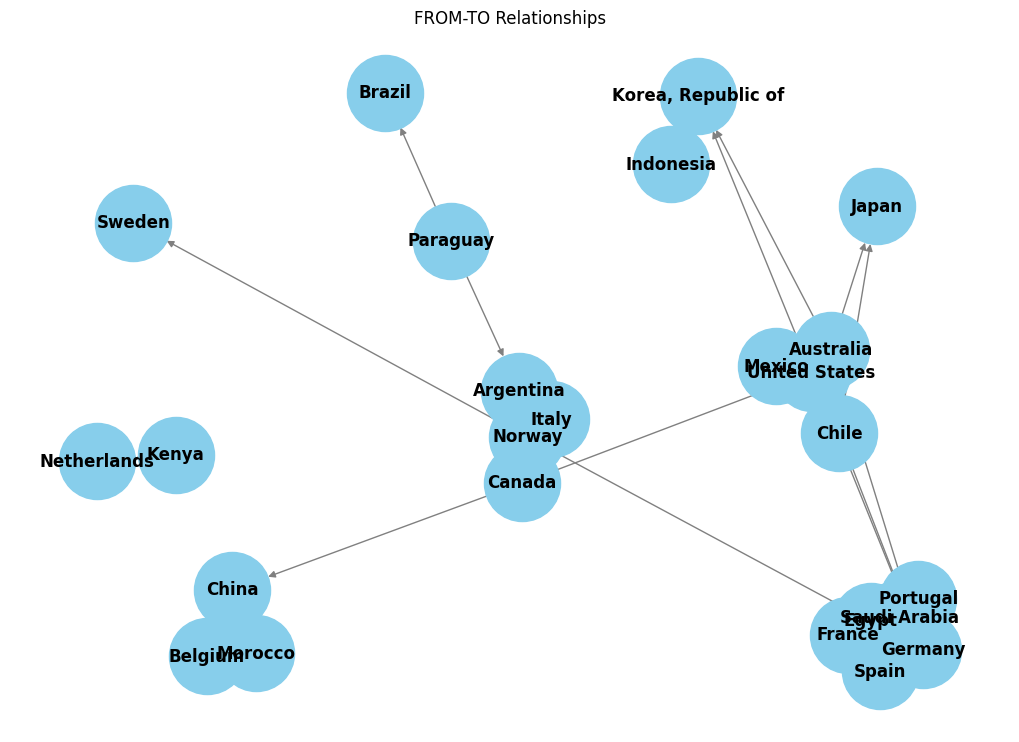

In [333]:
# Draw the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", 
        font_size=12, font_weight="bold", edge_color="gray", arrows=True)
plt.title("FROM-TO Relationships")
plt.show()

In [334]:
# Export the results
path_export = os.path.join('out_rev', 'df_analyze_locations.xlsx')
df_analyze.to_excel(path_export, index=False)

## Get the prices

### Identify the tokens with a price

In [ ]:
# Using Gliner to extract entities with the price label

import torch
from gliner import GLiNER
from tqdm import tqdm

# Load the model
model = GLiNER.from_pretrained("knowledgator/gliner-multitask-large-v0.5")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the labels
labels = ["price"]

# Function to predict entities
def predict_entities(text, labels, model, device):
    # Ensure the text is in the correct format for the model
    if isinstance(text, str):
        # Model may directly take text as input, depending on implementation
        inputs = text
    else:
        raise TypeError("Expected a string input for text.")

    # Perform prediction
    with torch.no_grad():
        predictions = model.predict_entities(inputs, labels)
    
    return predictions

# Function to apply prediction with a progress bar
def predict_with_progress(df, labels, model, device):
    predictions = []
    for abstract in tqdm(df['abstract'], desc="Processing abstracts"):
        prediction = predict_entities(abstract, labels, model, device)
        predictions.append(prediction)
    return predictions

# Apply the function and add the results to the dataframe
#df_analyze=df_analyze[df_analyze['new_topic']==8]
#df_analyze['price'] = predict_with_progress(df_analyze, labels, model, device)


In [31]:
# Apply the function and add the results to the dataframe filtering out the topics
filter_out = [7,9,12,10,29,34,0,2,17]

df_analyze=df_analyze[~df_analyze['new_topic'].isin(filter_out)]

In [32]:
# Apply the function and add the results to the dataframe
df_analyze['price_tokens'] = predict_with_progress(df_analyze, labels, model, device)

# Save the results
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze.to_excel(path_export, index=True)

Processing abstracts: 100%|██████████| 5938/5938 [08:08<00:00, 12.16it/s]


### Clasify the price tokens

In [336]:
import ast
# Read the excel to df_analyze
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze = pd.read_excel(path_export)
df_analyze['price_tokens'] = df_analyze['price_tokens'].apply(ast.literal_eval)
df_analyze['prices'] = df_analyze['price_tokens'].apply(lambda x: [entity['text'] for entity in x])

In [337]:
# Find what the price is about using a QA model

from transformers import pipeline

# Load the pre-trained QA model
qa_model = pipeline('question-answering', model="distilbert-base-uncased-distilled-squad", device=0)

def qa_extract_relationship(abstract, prices):
    p_val = []
    for price in prices:
        #check if price contains a number
        if bool(re.search(r'\d', price)) == True:
            question = f"What costs {price}?"
            result = qa_model(question=question, context=abstract)
            p_x={result['answer']: price}
            p_val.append(p_x)
    return p_val

# Try the QA model on a single abstract
i =2375
text = df_analyze['abstract'][i]
price = df_analyze['prices'][i]

print(qa_extract_relationship(text, price))


[{'hydrogen cost': '5 €/kgH2'}, {'hydrogen cost': '3-4 €/kgH2'}]


In [341]:
# Save the results
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze.to_excel(path_export, index=True)

In [338]:
# Apply the QA model to the entire dataframe
df_analyze['price_relationships'] = df_analyze.apply(lambda x: qa_extract_relationship(x['abstract'], x['prices']), axis=1)

#### Standarized the price types
- By classifying with the labels LCOH, LCOE, etc
- Disgragate the dictionary in to type, value and unit

In [128]:
# Extract the relationships
relantion_txt = df_analyze['price_relationships'].explode()
relantion_txt.dropna(inplace=True)

# Apply the function to each item in the series
relantion_txt_keys = relantion_txt.apply(lambda x: list(x.keys()) if isinstance(x, dict) else None).explode()
relantion_txt_values = relantion_txt.apply(lambda x: list(x.values()) if isinstance(x, dict) else None).explode()

# Create a DataFrame with the results
df_relationships = pd.DataFrame({'key': relantion_txt_keys, 'price': relantion_txt_values})
df_relationships = df_relationships.groupby('key')['price'].agg(', '.join).reset_index()
df_relationships['count'] = df_relationships['price'].apply(lambda x: len(x.split(',')))

# Export the results for cleaning
path_export = os.path.join('out', 'priceRelation.xlsx')
df_relationships.to_excel(path_export, index=False)

In [342]:
# Import the excel with the relations cleaned
path_export = os.path.join('out_rev', 'priceRelation_clean.xlsx')
df_relationships = pd.read_excel(path_export)

# Create a dictionary with the relations
df_relationships = df_relationships.dropna(subset=['key_clean'])
priceRel_dict   = dict(zip(df_relationships['key'], df_relationships['key_clean']))

# Function to rename the keys in the relationships
def rename_key_dics(dics, mapping_dict):
    dics_list = []
    for t in dics:
        transformed_dict = {mapping_dict[k]: v for k, v in t.items() if k in mapping_dict}
        if transformed_dict:
            dics_list.append(transformed_dict)
    return dics_list

# Apply the function to the price_relationships column
df_analyze['price_relClean'] = df_analyze['price_relationships'].apply(lambda dics: rename_key_dics(dics, priceRel_dict))

In [469]:
# Function to disgragate the dictionary in to type, value and unit
def disgregate_dict(dics):
    dics_list = []
    for t in dics:
        for k, v in t.items():
            v = v.lower()
            v = v.replace('h2', 'Hyd').strip()
            v = v.replace('kg-1', 'kg*').strip()
            v = v.replace('kg -1', 'kg*').strip()
            match = re.match(r'[^\d]*([\d.]+)', v)
            if match:
                numeric_value_1 = (match.group(1))
                # Replace the numeric value with the extracted value
                v = v.replace(numeric_value_1, '').strip()
                match = re.match(r'(?:\s*to\s*|\s*-?\s*)[^\d]*([\d.]+)', v)
                if match:
                    numeric_value_2 = (match.group(1))
                    # Replace the numeric value with the extracted value
                    v = v.replace(numeric_value_2, '').strip()
                    transformed_dict_1 = {'type': k, 'value': numeric_value_1, 'unit': v}
                    transformed_dict_2 = {'type': k, 'value': numeric_value_2, 'unit': v}
                    dics_list.append(transformed_dict_1)
                    dics_list.append(transformed_dict_2)
                else:
                    transformed_dict = {'type': k, 'value': numeric_value_1, 'unit': v}
                    dics_list.append(transformed_dict)
                
        
    return dics_list

# Apply function to check the results
i = 21
print(df_analyze['price_relClean'][i])
print(disgregate_dict(df_analyze['price_relClean'][i]))

# Apply the function to the 'price_std' column
df_analyze['price_relMatrix'] = df_analyze['price_relClean'].apply(lambda dics: disgregate_dict(dics) if dics else {})

[{'LCOH': '7.13 $/kgH2'}, {'LCOH': '3.77 $/kgH2'}]
[{'type': 'LCOH', 'value': '7.13', 'unit': '$/kgHyd'}, {'type': 'LCOH', 'value': '3.77', 'unit': '$/kgHyd'}]


### LCOH: Find average price

- Export the units of the dict LCOH for cleaning

In [358]:
# Get the units from the group LCOH to clean the units
df_analyze['price_LCOH'] = df_analyze['price_relMatrix'].apply(lambda x: [entity for entity in x if entity['type'] == 'LCOH'])

# Explode the 'price_LCOH' column to check the units
df_LCOH = df_analyze.explode('price_LCOH')
df_LCOH['unit'] = df_LCOH['price_LCOH'].apply(lambda x: x['unit'] if isinstance(x, dict) else None)

# Create DF to group the units
count_unit = df_LCOH['unit'].dropna()
count_unit = Counter(count_unit)
df_count_unit = pd.DataFrame.from_dict(count_unit, orient='index', columns=['count']).reset_index()
df_count_unit.rename(columns={'index': 'unit'}, inplace=True)

# Export the results
path_export = os.path.join('out', 'priceUnit_LCOH.xlsx')
df_count_unit.to_excel(path_export, index=False)

- Create the dictionary with the cleaned units values

In [491]:
# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_LCOH_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# If cell is empty, fill with 'check'
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_LCOH_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

- Apply the function to standarized the units

In [471]:
# Function to rename the values of the field 'unit' to the cleaned values
def rename_fieldValues(dict_x, mapping_dict, field='unit'):
    dict_cc = copy.deepcopy(dict_x)
    #for t in dics:
    if dict_cc[field] in mapping_dict:
        dict_cc[field] = mapping_dict[dict_cc[field]]        
    return dict_cc

df_analyze['price_LCOH'] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_LCOH_dict) for entity in x if entity['type'] == 'LCOH'])

- Complete the cleaning of the units for the LCOH prices

In [498]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=20):
    
    location = abstract.find(value)
    v = abstract[location-spaces:location+len(value)+1+spaces]

    v = v.replace(value, '').strip()
    v = v.lower()
    #v = v.replace(' ', '').strip()
    v = v.replace('h2', 'Hyd').strip()
    v = v.replace('per', '/').strip()
    v = v.replace('kilogram', 'kg').strip()
    v = v.replace(',', ' ').strip()   
    v = v.replace('.', ' ').strip()
    v = v.replace('$', 'USD').strip()
    v = v.replace('€', 'EUR').strip()
    v = v.replace('euro', 'EUR').strip()
    v = v.replace('eur', 'EUR').strip()
    v = v.replace('⋅', '').strip()
    v = v.replace('EURkgHyd', 'EUR/kg').strip()
    v = v.replace('to', '').strip()

    v = v.replace(' ', '').strip()
    v = v.replace('kg-1', '/kg').strip()
    v = v.replace('kg−1', '/kg').strip()
    v = v.replace('kgHyd−1', '/kgHyd').strip()

    v = v.replace('//', '/').strip()
        
    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    v = v.replace('-', '').strip()

    for i in range(10):
        v = v.replace(str(i), '').strip()
 
    v = v.replace('USD∼kgh', 'USD/kgHyd').strip()
    v = v.replace('USD kg Hyd', 'USD/kgHyd').strip()
    v = v.replace('USDto', 'USD').strip()
    v = v.replace('USDus', 'USD').strip()

    return v

# Function to find if part of the text is in the mapping dictionary
def check_mapping(text, mapping):
    results = []
    for key, value in mapping.items():
        if key in text:
            results.append(value)
    if len(set(results)) == 1:
        return set(results)

# Explode the dicts in the 'price_LCOH' column
df_LCOH = df_analyze.explode('price_LCOH')
df_LCOH = df_LCOH.dropna(subset=['price_LCOH'])

# Select the columns to keep
df_LCOH =df_LCOH[['title', 'abstract', 'price_LCOH']]

# Check if unit is in the mapping dictionary
df_LCOH['check'] = df_LCOH['price_LCOH'].apply(lambda x: x['unit'] in priceUnit_LCOH_dict.values())
df_LCOH['referenceTxt'] = df_LCOH.apply(lambda x: extract_referenceTxt(x['abstract'], x['price_LCOH']['value']), axis=1)

# Check if any value coincides with the mapping_dict
df_LCOH['find_Unit'] = df_LCOH['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_LCOH_dict))


- Update de df_analize with the values found, droping the still missing values

In [516]:
# Update the price_LCOH_std unit with the check values
def update_unit(dict, find_Unit, check):
    if check==False:
        if find_Unit:
            dict['unit'] = find_Unit.pop()
            return dict
        else:
            return None
    else:
        return dict

df_LCOH['price_LCOH'] = df_LCOH.apply(lambda x: update_unit(x['price_LCOH'], x['find_Unit'], x['check']), axis=1)
df_LCOH = df_LCOH.dropna(subset=['price_LCOH'])

df_LCOH_grouped = df_LCOH.groupby(df_LCOH.index)['price_LCOH'].apply(list)
df_analyze['price_LCOH_rev'] = df_LCOH_grouped

- Convert the values to USD/kgH2

In [570]:
# Extract the units from the group LCOH to clean the units
df_units_LCOH = df_analyze['price_LCOH_rev'].explode().dropna()
df_units_LCOH = df_units_LCOH.apply(lambda x: x['unit'])
print(df_units_LCOH.unique()) 

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units_LCOH})
df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
print(df_units['Currency'].unique())

dict_currency= {
    'USD': 1,
    'cUSD': 0.01,
    'EUR': 1.11,
    'cEUR': 0.0111,
    'AUD': 0.68,
    'CNY': 0.14,
    'GBP': 1.32,
    'NOK': 0.095,
    'SEK': 0.098
}

df_prices = df_analyze[['title', 'abstract', 'new_topic', 'price_LCOH_rev']]

def convert_prices(prices, dict_currency):
    results = []
    for price in prices:
        currency = price['unit'].split('/')[0] 
        if currency in dict_currency:
            try:
                value_price = float(price['value'])
                price['value'] = value_price * dict_currency[currency]
                price['unit'] = 'USD/'+price['unit'].split('/')[1] 
                results.append(price)
            except ValueError:
                None
    return results   

df_prices = df_prices.dropna(subset='price_LCOH_rev')
df_prices['price_LCOH_USD'] = df_prices['price_LCOH_rev'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.explode('price_LCOH_USD')
df_prices['price_USD'] = df_prices['price_LCOH_USD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_LCOH_USD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='USD/kgH2']



['USD/kgH2' 'USD/kWh' 'USD/MWh' 'GBP/kgH2' 'USD/TnH2' 'USD/GJ']
['USD' 'GBP']


In [578]:
# Plot the results
df_prices_filtered = df_prices[df_prices['new_topic'] == 3]
fig = px.box(df_prices_filtered, x='price_USD', range_x=[0, 40])
fig.update_layout(title='Price of LCOH by topic')
fig.show()

### LCOE: Find average price

- Export the units of the dict LCOH for cleaning

In [579]:
# Get the units from the group LCOH to clean the units
df_analyze['price_LCOE'] = df_analyze['price_relMatrix'].apply(lambda x: [entity for entity in x if entity['type'] == 'LCOE'])

# Explode the 'price_LCOH' column to check the units
df_LCOH = df_analyze.explode('price_LCOE')
df_LCOH['unit'] = df_LCOH['price_LCOE'].apply(lambda x: x['unit'] if isinstance(x, dict) else None)

# Create DF to group the units
count_unit = df_LCOH['unit'].dropna()
count_unit = Counter(count_unit)
df_count_unit = pd.DataFrame.from_dict(count_unit, orient='index', columns=['count']).reset_index()
df_count_unit.rename(columns={'index': 'unit'}, inplace=True)

# Export the results
path_export = os.path.join('out', 'priceUnit_LCOE.xlsx')
df_count_unit.to_excel(path_export, index=False)

- Create the dictionary with the cleaned units values

In [606]:
# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_LCOE_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# If cell is empty, fill with 'check'
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_LCOE_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

- Apply the function to standarized the units

In [586]:
# Function to rename the values of the field 'unit' to the cleaned values
def rename_fieldValues(dict_x, mapping_dict, field='unit'):
    dict_cc = copy.deepcopy(dict_x)
    #for t in dics:
    if dict_cc[field] in mapping_dict:
        dict_cc[field] = mapping_dict[dict_cc[field]]        
        return dict_cc

df_analyze['price_LCOE'] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_LCOH_dict) for entity in x if entity['type'] == 'LCOE'])

- Complete the cleaning of the units for the LCOH prices

In [608]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=15):
    
    location = abstract.find(value)
    v = abstract[location-spaces:location+len(value)+1+spaces]

    v = v.replace(value, '').strip()
    v = v.lower()
    #v = v.replace(' ', '').strip()
    v = v.replace('h2', 'Hyd').strip()
    v = v.replace('per', '/').strip()
    v = v.replace('kilogram', 'kg').strip()
    v = v.replace(',', ' ').strip()   
    v = v.replace('.', ' ').strip()
    v = v.replace('$', 'USD').strip()
    v = v.replace('usd', 'USD').strip()
    v = v.replace('€', 'EUR').strip()
    v = v.replace('£', 'GBP').strip()
    v = v.replace('euro', 'EUR').strip()
    v = v.replace('eur', 'EUR').strip()
    v = v.replace('⋅', '/').strip()
    v = v.replace('EURkgHyd', 'EUR/kg').strip()
    v = v.replace('to', '').strip()
    v = v.replace('kwh', 'kWh').strip()
    v = v.replace('mwh', 'MWh').strip()

    v = v.replace(' ', '').strip()
    v = v.replace('kg-1', '/kg').strip()
    v = v.replace('kg−1', '/kg').strip()
    v = v.replace('kgHyd−1', '/kgHyd').strip()

    v = v.replace('//', '/').strip()
        
    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    v = v.replace('-', '').strip()

    for i in range(10):
        v = v.replace(str(i), '').strip()
 
    v = v.replace('USD∼kgh', 'USD/kgHyd').strip()
    v = v.replace('USD kg Hyd', 'USD/kgHyd').strip()
    v = v.replace('USDto', 'USD').strip()
    v = v.replace('USDus', 'USD').strip()
    v = v.replace('megawatthour', 'MWh')


    return v

# Function to find if part of the text is in the mapping dictionary
def check_mapping(text, mapping):
    results = []
    for key, value in mapping.items():
        if key in text:
            results.append(value)
    if len(set(results)) == 1:
        return set(results)

# Explode the dicts in the 'price_LCOH' column
df_LCOE = df_analyze.explode('price_LCOE')
df_LCOE = df_LCOE.dropna(subset=['price_LCOE'])

# Select the columns to keep
df_LCOE =df_LCOE[['title', 'abstract', 'price_LCOE']]

# Check if unit is in the mapping dictionary
df_LCOE['check'] = df_LCOE['price_LCOE'].apply(lambda x: x['unit'] in priceUnit_LCOE_dict.values())
df_LCOE['referenceTxt'] = df_LCOE.apply(lambda x: extract_referenceTxt(x['abstract'], x['price_LCOE']['value']), axis=1)

# Check if any value coincides with the mapping_dict
df_LCOE['find_Unit'] = df_LCOE['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_LCOE_dict))


- Update de df_analize with the values found, droping the still missing values

In [612]:
# Update the price_LCOH_std unit with the check values
def update_unit(dict, find_Unit, check):
    if check==False:
        if find_Unit:
            dict['unit'] = find_Unit.pop()
            return dict
        else:
            return None
    else:
        return dict

df_LCOE['price_LCOE'] = df_LCOE.apply(lambda x: update_unit(x['price_LCOE'], x['find_Unit'], x['check']), axis=1)
df_LCOE = df_LCOE.dropna(subset=['price_LCOE'])

df_LCOE_grouped = df_LCOE.groupby(df_LCOE.index)['price_LCOE'].apply(list)
df_analyze['price_LCOE_rev'] = df_LCOE_grouped

- Convert the values to USD/kgH2

In [615]:
# Extract the units from the group LCOH to clean the units
df_units_LCOE = df_analyze['price_LCOE_rev'].explode().dropna()
df_units_LCOE = df_units_LCOE.apply(lambda x: x['unit'])
print(df_units_LCOE.unique()) 

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units_LCOE})
df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
print(df_units['Currency'].unique())

dict_currency= {
    'USD': 1,
    'cUSD': 0.01,
    'EUR': 1.11,
    'cEUR': 0.0111,
    'AUD': 0.68,
    'CNY': 0.14,
    'GBP': 1.32,
    'NOK': 0.095,
    'SEK': 0.098
}

df_prices = df_analyze[['title', 'abstract', 'new_topic', 'price_LCOE_rev']]

def convert_prices(prices, dict_currency):
    results = []
    for price in prices:
        currency = price['unit'].split('/')[0] 
        if currency in dict_currency:
            try:
                value_price = float(price['value'])
                price['value'] = value_price * dict_currency[currency]
                price['unit'] = 'USD/'+price['unit'].split('/')[1] 
                results.append(price)
            except ValueError:
                None
    return results   

df_prices = df_prices.dropna(subset='price_LCOE_rev')
df_prices['price_LCOE_USD'] = df_prices['price_LCOE_rev'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.explode('price_LCOE_USD')
df_prices['price_USD'] = df_prices['price_LCOE_USD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_LCOE_USD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='USD/kWH']



['USD/kWh' 'cUSD/kWh' 'USD/MWh' 'EUR/MWh' 'USD/kgH2' 'EUR/kWh']
['USD' 'cUSD' 'EUR']


In [618]:
# Plot the results
#df_prices_filtered = df_prices[df_prices['new_topic'] == 3]
fig = px.box(df_prices_filtered, x='price_USD')
fig.update_layout(title='Price of LCOE by topic')
fig.show()